In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
%matplotlib inline
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, Normalizer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

**IMPORT DATASET**

1st of all, let's import the dataset

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
train.shape, test.shape

((891, 12), (418, 11))

**A. DESCRIPTIVE STATISTICS**

All right, using few lines of code, let's try to describe the data using desctiptive statistics

In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


**A.1 Numerical Attributes**

From above simple code, we can see some numerical attributes described by some simple descriptive statistics. **What do we get here?**
1. **Survived**: the sample mean of this training data is 0,38, which could means *only about that percentage of passengers survived from titanic accident*

2. **Pclass** (Passenger Class: there are 3 class of passenger. At Q2(50%) and Q3(75%) we could see the value is 3, which could means *there are minimum 50% (or more) passengers which is 3rd class passengers*. It seems logical since lower class usually have cheaper ticket prize, and more quota for that class

3. **Age**: from train and test data, the count values seems different from the others. yes, **Age attribute contains missing values**. Another usefull information, the mean/average age on training data is 29 years old, which is 1 years older than the median value of the mean (30 mean and 27 median on test dataset), so what does it mean?
    
    it means the distributions of age values have **right skew**, which we expect some outliers in the *higher age value* (on the right size ofthe axis. As we can see, on the training and test dataset max value is 80 and 76 respectively.
    
4. **SibSp and Parch**: these attributes indicate number of SIblings or spouses, and Parent or Children number aboard. From the mean value, seems *majority of the passengers is alone (neither have SibSp or Parch)*. It is interesting that we see the maximum value have 8 SibSp and 9 ParCh, *maybe the oldest person brought his/her entire family on the ship*

5. **Fare**: there are huge difference between mean and median value of this attributes, which is logical. *Many passengers from 3rd class which always have lower Fare*, on the other hand, we have so high value on max of Fare here, which seems an outlier that affect the average of this attributes (**again, right skew**). **Fare attribute contain 1 missing value on test dataset**

In [6]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Scanlan, Mr. James",male,347082,B96 B98,S
freq,1,577,7,4,644


In [7]:
test.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Sap, Mr. Julius",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


**A.2 Categorical Attributes**
Now, we're dealing with categorical attributes. From describe method above, we get some new information:
1. **Name**: all names are unique (nothing special), *but they contains title*. maybe we can do some feature engineering later to get new attributes which could improve our prediction later.

2.  **Sex**: or *gender*. consist of 2 categories, male and female, with both on training and test dataset, male have higher frequency (approximately 60 : 40)

3.  **Ticket**: soooo many unique values for this attributes. Maybe I'll just drop this attribute for now and include it for future research

4. **Cabin**: so many **missing values** here (*204 filled from 891 possible* on training dataset and *91 filled from 418 possible* on test dataset). *Maybe some passengers*, which we already know, 3rd class or some low Fare paid passenger, **don't have Cabin**.

5. **Embarked**: There are **2 missing values** on training dataset. from train and test dataset, we know that most of Passengers embarked from S (*what's this "S" anyway?*).

**B. EXPLORATORY DATA ANALYSIS**

In [8]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Text(0.5,1,'Survival Rate by Embarked')

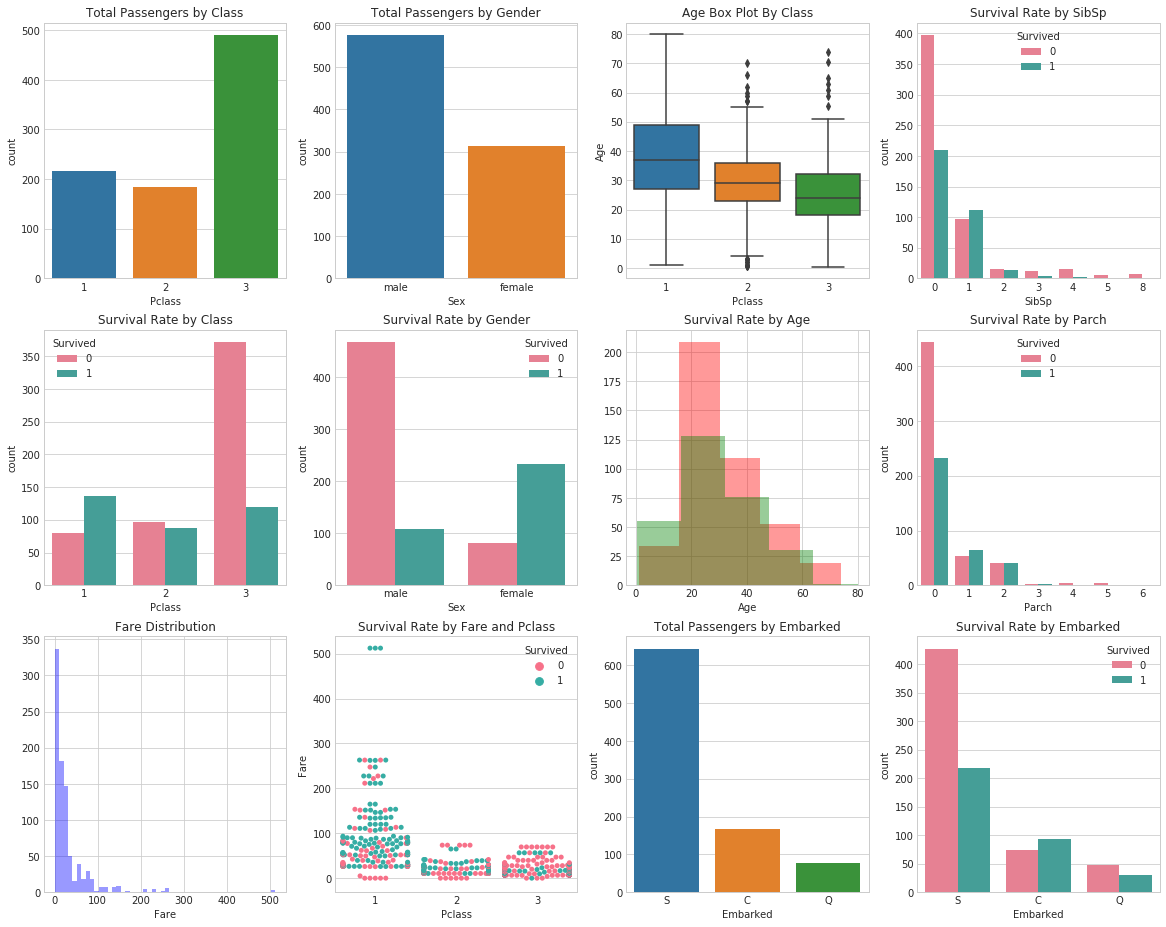

In [9]:
f,ax = plt.subplots(3,4,figsize=(20,16))
sns.countplot('Pclass',data=train,ax=ax[0,0])
sns.countplot('Sex',data=train,ax=ax[0,1])
sns.boxplot(x='Pclass',y='Age',data=train,ax=ax[0,2])
sns.countplot('SibSp',hue='Survived',data=train,ax=ax[0,3],palette='husl')
sns.distplot(train['Fare'].dropna(),ax=ax[2,0],kde=False,color='b')
sns.countplot('Embarked',data=train,ax=ax[2,2])

sns.countplot('Pclass',hue='Survived',data=train,ax=ax[1,0],palette='husl')
sns.countplot('Sex',hue='Survived',data=train,ax=ax[1,1],palette='husl')
sns.distplot(train[train['Survived']==0]['Age'].dropna(),ax=ax[1,2],kde=False,color='r',bins=5)
sns.distplot(train[train['Survived']==1]['Age'].dropna(),ax=ax[1,2],kde=False,color='g',bins=5)
sns.countplot('Parch',hue='Survived',data=train,ax=ax[1,3],palette='husl')
sns.swarmplot(x='Pclass',y='Fare',hue='Survived',data=train,palette='husl',ax=ax[2,1])
sns.countplot('Embarked',hue='Survived',data=train,ax=ax[2,3],palette='husl')

ax[0,0].set_title('Total Passengers by Class')
ax[0,1].set_title('Total Passengers by Gender')
ax[0,2].set_title('Age Box Plot By Class')
ax[0,3].set_title('Survival Rate by SibSp')
ax[1,0].set_title('Survival Rate by Class')
ax[1,1].set_title('Survival Rate by Gender')
ax[1,2].set_title('Survival Rate by Age')
ax[1,3].set_title('Survival Rate by Parch')
ax[2,0].set_title('Fare Distribution')
ax[2,1].set_title('Survival Rate by Fare and Pclass')
ax[2,2].set_title('Total Passengers by Embarked')
ax[2,3].set_title('Survival Rate by Embarked')

> Some usefull information:
* clearly, we can see most passengers are in class 3, which have least survival probability here
* from Sex attribute, we can see total male Passengers is almost 2 times of female passengers, but lower survival probability *maybe male passengers tend to save their lady first?*
* from above figure, we can try to input missing age by class
    * Pclass 1, Age average approximately = 37
    * Pclass 2, Age average approximately = 29
    * Pclass 3, Age average approximately = 24
* also on age attributes, we already clearly see the age distributions follow normal distribution with right skew
* it seems passenger with Sibling/Spouse, or have parent/children aboard, have higher survival rate than passenger which is alone!

In [10]:
train['Cabin'].value_counts().head()

B96 B98        4
C23 C25 C27    4
G6             4
F33            3
D              3
Name: Cabin, dtype: int64

Now we got new information, some passenger have multiple cabin listed.
for each passenger, I'll just try to create a new feature called **'Deck'** with first letter from the Cabin as its value.
if passenger have multiple deck listed, I'll just use the higher class deck (ex: A and D, I'll just use A as the value)

thanks to this discussion: https://www.kaggle.com/c/titanic/discussion/4693

"first class had the top decks (A-E), second class (D-F), and third class (E-G). It also makes sense that the people towards the top (higher decks, higher pclass) more likely survived, because they were closer to the lifeboats."

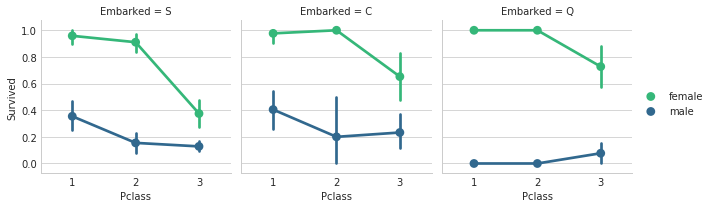

In [11]:
g = sns.FacetGrid(col='Embarked',data=train)
g.map(sns.pointplot,'Pclass','Survived','Sex',palette='viridis',hue_order=['male','female'])
g.add_legend()

We got a lot information from above visualization, such as:
* Female passenger Embarked from S and Q have high survival rate
* Female from class 1 and 2 Embarked from Queenstown absolutely survived!!!
* Male Embarked from Queenstown with Pclass 1, have lowest survival rate!

**C. SUMMARY**

Before we do this journey further, let's summarize our information and so far and what we should do with them.
* **Survived:**
    * The value we should predict using test dataset. It is numerical with binary value 0 (Dead) and 1 (Survived)
    
* **Pclass:**
    * The data type is categorical, level of measurement is qualitative->ordinal, since the level seems like 1>2>3.
    * Since this is an ordinal, maybe we should **scale its value from 0 to 1** so we can keep the level information from this variable.
    
* **Name:**
    * The data type is categorical, level of measurement is qualitative->nominal.
    * We should include this variable in **Feature Engineering** process to extract the title value which maybe could improve our prediction result.
    
* **Sex:**
    * The data type is categorical, level of measurement is qualitative->nominal.
    * Since this is a categorical, maybe we should change the value to binary value 0 for male and 1 for female. We'll do this on **Data Preparation** process.
    
* **Age:**
    * The data type is numerical->continous with level of measurement is quantitative->ratio.
    * we should fill the **missing values**
    * in order to divide the train data so the machine learning could understand better, I prefer to change the level of measurement to quantitative->interval using the group of age (maybe child, teenagers, young adult, adult) on **Feature Engineering** process.
    
* **SibSp & Parch:**
    * The data type is numerical, level of measurement is quantitative->ratio.
    * Passenger with Sibling/Spouse, or have parent/children aboard, have higher survival rate than passenger which is alone!
    * So I'll create a new feature based on this attribute called 'is_alone', I'll do this on **Feature engineering** process.
    
* **Ticket:**
    * *I'' drop this for now.*
    
* **Fare:**
    * The data type is numerical->continous with level of measurement is quantitative->ratio.
    * There is 1 missing value in test dataset
    * Since it seems there is an increasing level of passenger based on the Fare, I'll just scale the value of this variable from 0 to 1 in **Feature Engineering** process.
    
* **Cabin:**
    * The data type is categorical, level of measurement is qualitative->ordinal, since the level seems like A>B>C>D..
    * Some passenger have multiple cabin listed.
    * there are many **missing values** on this attributes, I'll fill it with 'No Cabin' string.
    * for each passenger, I'll just try to create a new feature called **'Deck'** with first letter from the Cabin as its value on **Feature Engineering** process.
    * if passenger have multiple deck listed, I'll just use the higher class deck (ex: A and D, I'll just use A as the value)
    * Because this variable is ordinal, I'll further change the letter value to be scaled from 0 to 1 in **Feature Engineering** process
    
* **Embarked:**
    * The data type is categorical, level of measurement is qualitative->nominal.
    * Since this is a categorical, maybe we should **get dummies** of this variable.
    * there are 2 missing values on training dataset

**D. DEALING WITH MISSING VALUES**

from the summary above, we should fill missing values in **Age**, 1 value of **Fare** in test, and 2 values of **Embarked** in training. So, let's do this.

wait, let's check the missing values using heatmap.

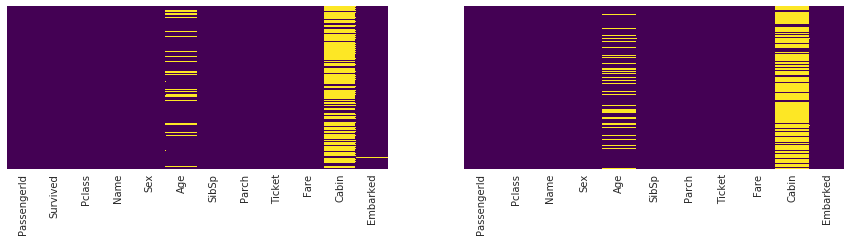

In [12]:
f,ax = plt.subplots(1,2,figsize=(15,3))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis',ax=ax[0])
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis',ax=ax[1])

**D.1 Filling missing values in Age**

let's see the plot 1st:

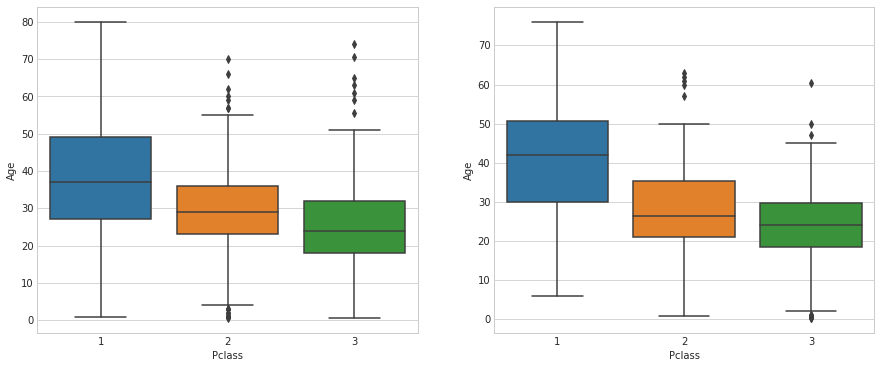

In [13]:
f,ax = plt.subplots(1,2,figsize=(15,6))
sns.boxplot(x='Pclass',y='Age',data=train,ax=ax[0])
sns.boxplot(x='Pclass',y='Age',data=test,ax=ax[1])

from Above information: we can fill Age Information with:
* train: PClass 1 = 37, PClass 2 = 29, PClass 3 = 24
* test: PClass 1 = 39, PClass 2 = 28, PClass 3 = 25

In [14]:
def fill_age_train(cols):
    Age = cols[0]
    PClass = cols[1]
    
    if pd.isnull(Age):
        if PClass == 1:
            return 37
        elif PClass == 2:
            return 29
        else:
            return 24
    else:
        return Age

def fill_age_test(cols):
    Age = cols[0]
    PClass = cols[1]
    
    if pd.isnull(Age):
        if PClass == 1:
            return 39
        elif PClass == 2:
            return 28
        else:
            return 25
    else:
        return Age

In [15]:
train['Age'] = train[['Age','Pclass']].apply(fill_age_train,axis=1)
test['Age'] = test[['Age','Pclass']].apply(fill_age_test,axis=1)

**D.2 Filling missing values in Fare, Cabin and Embarked**

In [16]:
test['Fare'].fillna(stat.mode(test['Fare']),inplace=True)
train['Embarked'].fillna('S',inplace=True)
train['Cabin'].fillna('No Cabin',inplace=True)
test['Cabin'].fillna('No Cabin',inplace=True)

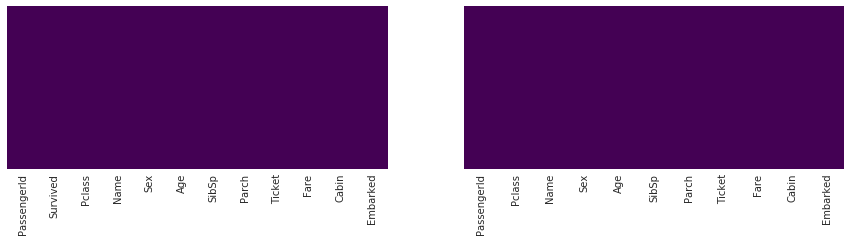

In [17]:
f,ax = plt.subplots(1,2,figsize=(15,3))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis',ax=ax[0])
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis',ax=ax[1])

**IT'S CLEAR!!!** ready for feature engineering, but, we'll drop Ticket first

In [18]:
train.drop('Ticket',axis=1,inplace=True)
test.drop('Ticket',axis=1,inplace=True)

In [19]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,No Cabin,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,No Cabin,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,No Cabin,S


**E. FEATURE ENGINEERING**

from summary above, we will do some work on **Name, Age, SibSP & Parch, Fare, Cabin**. Let's do this!

In [20]:
#combine dataset 1st for easier Feature Engineering
train['IsTrain'] = 1
test['IsTrain'] = 0
df = pd.concat([train,test])

In [21]:
#Scaler Initiation
scaler = MinMaxScaler()

**E.1 Feature Engineering: Name -> Title**

In [22]:
df['Title'] = df['Name'].str.split(', ').str[1].str.split('.').str[0]
df['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Major             2
Mlle              2
Lady              1
Mme               1
Don               1
Capt              1
Sir               1
Dona              1
Jonkheer          1
the Countess      1
Name: Title, dtype: int64

for these rare title, we'll convert them to 'Others', except **Mme** will be converted to Mrs, **Ms and Mlle** to Miss

In [23]:
df['Title'].replace('Mme','Mrs',inplace=True)
df['Title'].replace(['Ms','Mlle'],'Miss',inplace=True)
df['Title'].replace(['Dr','Rev','Col','Major','Dona','Don','Sir','Lady','Jonkheer','Capt','the Countess'],'Others',inplace=True)
df['Title'].value_counts()

Mr        757
Miss      264
Mrs       198
Master     61
Others     29
Name: Title, dtype: int64

In [24]:
df.drop('Name',axis=1,inplace=True)
df.head()

,Age,Cabin,Embarked,Fare,IsTrain,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title
0,22.0,No Cabin,S,7.2500,1,0,1,3,male,1,0.0,Mr
1,38.0,C85,C,71.2833,1,0,2,1,female,1,1.0,Mrs
2,26.0,No Cabin,S,7.9250,1,0,3,3,female,0,1.0,Miss
3,35.0,C123,S,53.1000,1,0,4,1,female,1,1.0,Mrs
4,35.0,No Cabin,S,8.0500,1,0,5,3,male,0,0.0,Mr


**E.2 Feature Engineering: Age -> AgeGroup**

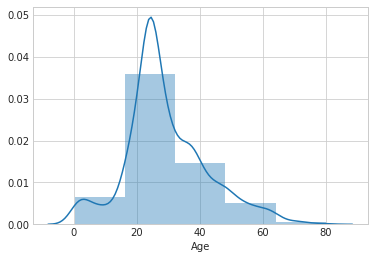

In [25]:
sns.distplot(df['Age'],bins=5)

I'll divide age to 5 categories, they are, Child(<=19), Young Adult(>19,<=30), Adult(>30,<=45), Old(>45,<=63), Veteran(>63), 

with: **child = 0, Young Adult = 1, Adult = 2, Old = 3, Veteran = 4**

In [26]:
df['AgeGroup'] = df['Age']
df.loc[df['AgeGroup']<=19, 'AgeGroup'] = 0
df.loc[(df['AgeGroup']>19) & (df['AgeGroup']<=30), 'AgeGroup'] = 1
df.loc[(df['AgeGroup']>30) & (df['AgeGroup']<=45), 'AgeGroup'] = 2
df.loc[(df['AgeGroup']>45) & (df['AgeGroup']<=63), 'AgeGroup'] = 3
df.loc[df['AgeGroup']>63, 'AgeGroup'] = 4

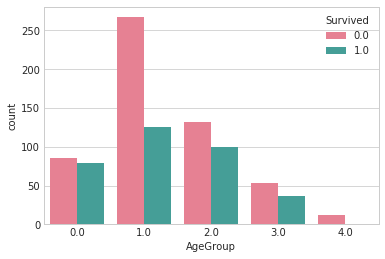

In [27]:
sns.countplot(x='AgeGroup',hue='Survived',data=df[df['IsTrain']==1],palette='husl')

In [28]:
df.drop('Age',axis=1,inplace=True)
df.head()

,Cabin,Embarked,Fare,IsTrain,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title,AgeGroup
0,No Cabin,S,7.2500,1,0,1,3,male,1,0.0,Mr,1.0
1,C85,C,71.2833,1,0,2,1,female,1,1.0,Mrs,2.0
2,No Cabin,S,7.9250,1,0,3,3,female,0,1.0,Miss,1.0
3,C123,S,53.1000,1,0,4,1,female,1,1.0,Mrs,2.0
4,No Cabin,S,8.0500,1,0,5,3,male,0,0.0,Mr,2.0


**E.3 Feature Engineering: SibSp & Parch -> IsAlone**

In [29]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1 #himself
df['IsAlone'] = 0
df.loc[df['FamilySize']==1, 'IsAlone'] = 1

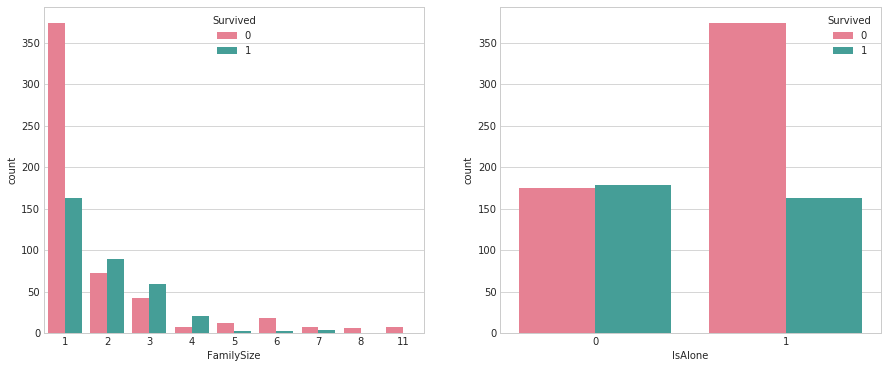

In [30]:
#checking correlation with survival rate
f,ax = plt.subplots(1,2,figsize=(15,6))
sns.countplot(df[df['IsTrain']==1]['FamilySize'],hue=train['Survived'],ax=ax[0],palette='husl')
sns.countplot(df[df['IsTrain']==1]['IsAlone'],hue=train['Survived'],ax=ax[1],palette='husl')

from both figures, I can assume that if a passenger have family onboard, **the survival rate will increase to approximately 50%.**

because we already have the information using is_alone feature only, *I'll just drop SibSp, Parch, and FamilySize*

In [31]:
df.drop(['SibSp','Parch','FamilySize'],axis=1,inplace=True)
df.head()

,Cabin,Embarked,Fare,IsTrain,PassengerId,Pclass,Sex,Survived,Title,AgeGroup,IsAlone
0,No Cabin,S,7.2500,1,1,3,male,0.0,Mr,1.0,0
1,C85,C,71.2833,1,2,1,female,1.0,Mrs,2.0,0
2,No Cabin,S,7.9250,1,3,3,female,1.0,Miss,1.0,1
3,C123,S,53.1000,1,4,1,female,1.0,Mrs,2.0,0
4,No Cabin,S,8.0500,1,5,3,male,0.0,Mr,2.0,1


In [32]:
df.head()

,Cabin,Embarked,Fare,IsTrain,PassengerId,Pclass,Sex,Survived,Title,AgeGroup,IsAlone
0,No Cabin,S,7.2500,1,1,3,male,0.0,Mr,1.0,0
1,C85,C,71.2833,1,2,1,female,1.0,Mrs,2.0,0
2,No Cabin,S,7.9250,1,3,3,female,1.0,Miss,1.0,1
3,C123,S,53.1000,1,4,1,female,1.0,Mrs,2.0,0
4,No Cabin,S,8.0500,1,5,3,male,0.0,Mr,2.0,1


**E.4 Feature Engineering: Cabin -> Deck**

In [33]:
df['Deck'] = df['Cabin']
df.loc[df['Deck']!='No Cabin','Deck'] = df[df['Cabin']!='No Cabin']['Cabin'].str.split().apply(lambda x: np.sort(x)).str[0].str[0]
df.loc[df['Deck']=='No Cabin','Deck'] = 'N/A'

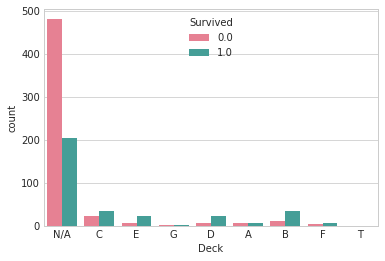

In [34]:
sns.countplot(x='Deck',hue='Survived',data=df[df['IsTrain']==1],palette='husl')

Well, now we can see clearly the survival rate based on passenger's Deck

In [35]:
df.loc[df['Deck']=='N/A', 'Deck'] = 0
df.loc[df['Deck']=='G', 'Deck'] = 1
df.loc[df['Deck']=='F', 'Deck'] = 2
df.loc[df['Deck']=='E', 'Deck'] = 3
df.loc[df['Deck']=='D', 'Deck'] = 4
df.loc[df['Deck']=='C', 'Deck'] = 5
df.loc[df['Deck']=='B', 'Deck'] = 6
df.loc[df['Deck']=='A', 'Deck'] = 7
df.loc[df['Deck']=='T', 'Deck'] = 0

In [36]:
df.drop('Cabin',axis=1,inplace=True)
df.head()

,Embarked,Fare,IsTrain,PassengerId,Pclass,Sex,Survived,Title,AgeGroup,IsAlone,Deck
0,S,7.2500,1,1,3,male,0.0,Mr,1.0,0,0
1,C,71.2833,1,2,1,female,1.0,Mrs,2.0,0,5
2,S,7.9250,1,3,3,female,1.0,Miss,1.0,1,0
3,S,53.1000,1,4,1,female,1.0,Mrs,2.0,0,5
4,S,8.0500,1,5,3,male,0.0,Mr,2.0,1,0


**E.5 Feature Engineering -> Scaling**

in this part, any features with level of measurement nominal -> ordinal, would be scaled from 0 to 1, they are **Fare, Pclass, and Deck**.

In [37]:
df[['Fare','Pclass','Deck']] = scaler.fit_transform(df[['Fare','Pclass','Deck']])

In [38]:
df.head()

,Embarked,Fare,IsTrain,PassengerId,Pclass,Sex,Survived,Title,AgeGroup,IsAlone,Deck
0,S,0.014151,1,1,1.0,male,0.0,Mr,1.0,0,0.000000
1,C,0.139136,1,2,0.0,female,1.0,Mrs,2.0,0,0.714286
2,S,0.015469,1,3,1.0,female,1.0,Miss,1.0,1,0.000000
3,S,0.103644,1,4,0.0,female,1.0,Mrs,2.0,0,0.714286
4,S,0.015713,1,5,1.0,male,0.0,Mr,2.0,1,0.000000


**F. FINAL DATA PREPARATION**

now after we got the features, lastly on data preprocessing, we need to get dummies on categorical data based on newly fresh baked dataframe, they are: **Embarked, Sex, Title, AgeGroup,**. 

In [39]:
def process_dummies(df,cols):
    for col in cols:
        dummies = pd.get_dummies(df[col],prefix=col,drop_first=True)
        df = pd.concat([df.drop(col,axis=1),dummies],axis=1)
    return df

In [40]:
df = process_dummies(df,['Embarked','Sex','Title','AgeGroup'])

In [41]:
df.head()

,Fare,IsTrain,PassengerId,Pclass,Survived,IsAlone,Deck,Embarked_Q,Embarked_S,Sex_male,Title_Miss,Title_Mr,Title_Mrs,Title_Others,AgeGroup_1.0,AgeGroup_2.0,AgeGroup_3.0,AgeGroup_4.0
0,0.014151,1,1,1.0,0.0,0,0.000000,0,1,1,0,1,0,0,1,0,0,0
1,0.139136,1,2,0.0,1.0,0,0.714286,0,0,0,0,0,1,0,0,1,0,0
2,0.015469,1,3,1.0,1.0,1,0.000000,0,1,0,1,0,0,0,1,0,0,0
3,0.103644,1,4,0.0,1.0,0,0.714286,0,1,0,0,0,1,0,0,1,0,0
4,0.015713,1,5,1.0,0.0,1,0.000000,0,1,1,0,1,0,0,0,1,0,0


**F.1 Divide df to train dataset and holdout for final testing purpose**

Before we continue to prediction section, let's divide again our data to **dataset** (formerly train data) and **holdout** (formerly test data)

In [42]:
dataset = df[df['IsTrain']==1]
dataset.drop(['IsTrain','PassengerId'],axis=1,inplace=True)
holdout = df[df['IsTrain']==0]
test_id = holdout['PassengerId']
holdout.drop(['IsTrain','PassengerId','Survived'],axis=1,inplace=True)

**F.2 Balancing Dataset**

in this part, I'll try to balance the prior of classes in train dataset to become 50% of survived passengers, and 50% not survived.

*Update: not used in latest update since it lower the submission score. But we surely need to balance the prior in some other cases to get better prediction result*

In [43]:
class_one_total = int(np.sum(dataset['Survived']))
class_zero_counter = 0
indices_to_remove = []

for i in range(dataset.shape[0]):
    if(dataset['Survived'].iloc[i] == 0):
        class_zero_counter += 1
        if(class_zero_counter > class_one_total):
            indices_to_remove.append(i)

#dataset.drop(dataset.index[indices_to_remove],inplace=True)

In [44]:
int(np.sum(dataset['Survived'])), dataset.shape[0]

(342, 891)

In [45]:
df.to_csv('titanic_dataset_preprocessed.csv',index=False)

**G. PREDICTION**

In this section, I'll do some work starts from splitting the dataset and do *cross_validation* with it, and maybe some *parameter tuning* to get better prediction result. Stay tune!!!

**G.1 Splitting the dataset**

In [46]:
X = dataset.drop(['Survived'],axis=1)
y = dataset['Survived'].astype('int')
#X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

**G.2 Model Creation**

In [47]:
model = RandomForestClassifier()
kf = KFold(n_splits=10,shuffle=True,random_state=101)
score = 0
train_indices, validation_indices = [],[]
for curr_train_indices, curr_validation_indices in kf.split(X):
    result = model.fit(X.iloc[curr_train_indices], y.iloc[curr_train_indices])
    curr_score = result.score(X.iloc[curr_validation_indices],y.iloc[curr_validation_indices])
    print(curr_score)
    
    if(curr_score > score):
        score = curr_score
        train_indices = curr_train_indices
        validation_indices = curr_validation_indices
print('Best Score: ',score)    

0.744444444444
0.85393258427
0.820224719101
0.831460674157
0.831460674157
0.831460674157
0.786516853933
0.85393258427
0.797752808989
0.887640449438
Best Score:  0.887640449438


In [48]:
param_grid = [
  {'n_estimators':[1,10,20,50,100,1000,3000], 'min_samples_leaf':[1,2,3,4,5], 'max_features':[3,5,7,9,10,'auto']},
 ]
grid = GridSearchCV(model,param_grid,n_jobs=4)
grid.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'n_estimators': [1, 10, 20, 50, 100, 1000, 3000], 'min_samples_leaf': [1, 2, 3, 4, 5], 'max_features': [3, 5, 7, 9, 10, 'auto']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [49]:
grid.best_params_, grid.best_score_

({'max_features': 9, 'min_samples_leaf': 3, 'n_estimators': 20},
 0.83838383838383834)

In [50]:
predictions = grid.predict(holdout)

**H. SUBMISSION**

Finally, let's submit our result

In [51]:
submission = pd.DataFrame({
    'PassengerId': test_id,
    'Survived': predictions
})

submission.to_csv('submission.csv',index=False)

**Notes:**

Like machine learning, I am still and always learning. In order to improve the result, I expect any idea or advice from you because I'm still a beginner in this field.

thanks for reading my long journey and happy kaggling :)

* Update 2018-01-11(2): Checked Embarked C graph which seems the color getting inversed between male and female. Solved using **Hue Order** parameter in seaborn pointplot.
* Update 2018-01-11: Added GridSearchCV and change the classifier to RandomForestClassifier, *LB goes up again to 0.78*
* Update 2018-01-10(4): trying to use KFold Cross Validation to train the model. Used SVM as the classifier.
* Update 2018-01-10(3): **Removed Balancing Dataset**, submission score going up again *0.77990* yeay :D, but still more works to do.
* Update 2018-01-10(2): Fixed some ordinal features from getting dummies to be scaled instead to keep the level information from ordinal features. *LB dropped to: 0.73684* T.T
* Update 2018-01-10: Fixed filling test dataset (AGE) with information from test dataset (I used information from train dataset before.
* Update 2018-01-09(2): Added sub section in **F. Final Data Preparation**, Balancing Dataset before doing any prediction. Submission score dropped to *0.77033*. Too bad :'D
* Update 2018-01-09: Commented **train_test_split** since I am not really using it now. I'll try to learn how to use it properly in sklearn machine learning convention. Maybe if you have any good reference, please kindly share it to me :)